## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [5]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [6]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [7]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [8]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [11]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [12]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

#### Comparing models

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [15]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 70142.55721218  67456.39127204  67318.3258893   70866.26065275]
Mean: 68945.8837566


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000. 

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma. 

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [16]:
from sklearn.svm import SVR

C_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000] ## YOUR VALUES FOR C ##
gamma_vals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000] ## YOUR VALUES FOR gamma ## 

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error', verbose=2)
grid_search_rbf.fit(X_tr, np.ravel(y_tr))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] C=0.0001, gamma=0.0001 ..........................................
[CV] ........................... C=0.0001, gamma=0.0001, total=   7.4s
[CV] C=0.0001, gamma=0.0001 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV] ........................... C=0.0001, gamma=0.0001, total=   8.3s
[CV] C=0.0001, gamma=0.0001 ..........................................
[CV] ........................... C=0.0001, gamma=0.0001, total=   7.4s
[CV] C=0.0001, gamma=0.001 ...........................................
[CV] ............................ C=0.0001, gamma=0.001, total=   7.6s
[CV] C=0.0001, gamma=0.001 ...........................................
[CV] ............................ C=0.0001, gamma=0.001, total=   6.8s
[CV] C=0.0001, gamma=0.001 ...........................................
[CV] ............................ C=0.0001, gamma=0.001, total=   6.6s
[CV] C=0.0001, gamma=0.01 ............................................
[CV] ............................. C=0.0001, gamma=0.01, total=   6.6s
[CV] C=0.0001, gamma=0.01 ............................................
[CV] ............................. C=0.0001, gamma=0.01, total=   6.8s
[CV] C=0.0001, gamma=0.01 ............................................
[CV] .

[CV] .............................. C=0.01, gamma=0.001, total=   7.3s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............................... C=0.01, gamma=0.01, total=   7.4s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............................... C=0.01, gamma=0.01, total=   7.5s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ............................... C=0.01, gamma=0.01, total=   8.4s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=   6.9s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=   6.8s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] ................................ C=0.01, gamma=0.1, total=   7.3s
[CV] C=0.01, gamma=1 .................................................
[CV] .

[CV] ................................... C=1, gamma=0.1, total=   7.6s
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total=   7.3s
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total=   7.1s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   7.0s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   7.5s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   7.0s
[CV] C=1, gamma=10 ...................................................
[CV] .................................... C=1, gamma=10, total=   8.2s
[CV] C=1, gamma=10 ...................................................
[CV] .

[CV] ................................... C=100, gamma=1, total=   7.3s
[CV] C=100, gamma=1 ..................................................
[CV] ................................... C=100, gamma=1, total=   6.9s
[CV] C=100, gamma=10 .................................................
[CV] .................................. C=100, gamma=10, total=   8.2s
[CV] C=100, gamma=10 .................................................
[CV] .................................. C=100, gamma=10, total=   8.2s
[CV] C=100, gamma=10 .................................................
[CV] .................................. C=100, gamma=10, total=   7.9s
[CV] C=100, gamma=100 ................................................
[CV] ................................. C=100, gamma=100, total=  12.7s
[CV] C=100, gamma=100 ................................................
[CV] ................................. C=100, gamma=100, total=  12.4s
[CV] C=100, gamma=100 ................................................
[CV] .

[CV] ................................ C=10000, gamma=10, total=   8.7s
[CV] C=10000, gamma=100 ..............................................
[CV] ............................... C=10000, gamma=100, total=  12.7s
[CV] C=10000, gamma=100 ..............................................
[CV] ............................... C=10000, gamma=100, total=  15.6s
[CV] C=10000, gamma=100 ..............................................
[CV] ............................... C=10000, gamma=100, total=  13.7s
[CV] C=10000, gamma=1000 .............................................
[CV] .............................. C=10000, gamma=1000, total=  13.4s
[CV] C=10000, gamma=1000 .............................................
[CV] .............................. C=10000, gamma=1000, total=  13.4s
[CV] C=10000, gamma=1000 .............................................
[CV] .............................. C=10000, gamma=1000, total=  13.4s
[CV] C=10000, gamma=10000 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 57.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [17]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 10000, 'gamma': 0.1}
62439.060542


### Performance on Test Set

In [18]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_te)

final_mse = mean_squared_error(y_te, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

60870.0951027


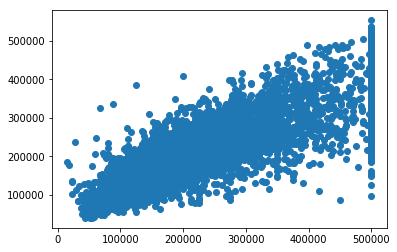

In [19]:
import matplotlib.pyplot as plt

plt.scatter(x=np.array(y_te), y=y_te_estimation)

plt.show()

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [20]:
from sklearn.metrics import accuracy_score

In [21]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [22]:
y_tr_b = 1*np.ravel(y_tr>=179700.0)
y_te_b = 1*np.ravel(y_te>=179700.0)

#### Linear SVM for classification

In [23]:
from sklearn.svm import LinearSVC

In [24]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_tr, y_tr_b)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [25]:
y_pred = lin_clf.predict(X_tr)
accuracy_score(y_tr_b, y_pred)

0.83845514950166111

In [26]:
# Calculate the RMSE

MSE_linearSVM = mean_squared_error(y_tr_b, y_pred)
RMSE_linearSVM = np.sqrt(MSE_linearSVM)
print(RMSE_linearSVM)

0.401926424235


### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

In [27]:
from sklearn.svm import SVC

In [28]:
SVC_Classifier = SVC(random_state = 42)

SVC_Classifier.fit(X_tr, y_tr_b)

y_pred_SVC_Classifier = SVC_Classifier.predict(X_tr)
accuracy_score(y_tr_b, y_pred_SVC_Classifier)

0.86614064230343302

In [29]:
#get the MSE and RMSE

MSE_SVC_Classifier = mean_squared_error(y_tr_b, y_pred_SVC_Classifier)
RMSE_SVC_Classifier = np.sqrt(MSE_SVC_Classifier)
print(RMSE_SVC_Classifier)

0.365867951174


Conclusion: The RMSE of SVC (0.365867951174) is lower than RMSE of Linear SVM (0.401926424235) and the Accuracy also improves by 3% from 0.83845514950166111 to 0.86614064230343302. So SVC turns out to be a better model over Linear SVM.

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [31]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(100, 1000)}
rnd_search_cv = RandomizedSearchCV(SVC_Classifier, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(X_tr, y_tr_b)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=465.515506623, gamma=0.0471507200336 ..........................
[CV] ........... C=465.515506623, gamma=0.0471507200336, total=   8.8s
[CV] C=465.515506623, gamma=0.0471507200336 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV] ........... C=465.515506623, gamma=0.0471507200336, total=   9.9s
[CV] C=465.515506623, gamma=0.0471507200336 ..........................
[CV] ........... C=465.515506623, gamma=0.0471507200336, total=   8.5s
[CV] C=988.871294733, gamma=0.00592216515651 .........................
[CV] .......... C=988.871294733, gamma=0.00592216515651, total=   6.2s
[CV] C=988.871294733, gamma=0.00592216515651 .........................
[CV] .......... C=988.871294733, gamma=0.00592216515651, total=   7.2s
[CV] C=988.871294733, gamma=0.00592216515651 .........................
[CV] .......... C=988.871294733, gamma=0.00592216515651, total=  10.0s
[CV] C=260.606503477, gamma=0.0950137751879 ..........................
[CV] ........... C=260.606503477, gamma=0.0950137751879, total=   8.2s
[CV] C=260.606503477, gamma=0.0950137751879 ..........................
[CV] ........... C=260.606503477, gamma=0.0950137751879, total=  10.3s
[CV] C=260.606503477, gamma=0.0950137751879 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.6min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002245E824DA0>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002245E802860>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [32]:
#Get the best estimator on Randomized SearchCV
rnd_search_cv.best_estimator_

SVC(C=891.26008398419549, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.025555406318355806,
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [33]:
#get the accuracy score on Random Search CV
y_pred_rnd_Classifier = rnd_search_cv.predict(X_tr)
accuracy_score(y_tr_b, y_pred_rnd_Classifier)

0.89507198228128459

In [34]:
MSE_RND_Classifier = mean_squared_error(y_tr_b, y_pred_rnd_Classifier)
RMSE_RND_Classifier = np.sqrt(MSE_RND_Classifier)
print(RMSE_SVC_Classifier)

0.365867951174


In [35]:
#Get the best Score.
rnd_search_cv.best_score_

0.87527685492801777

In [36]:
# Work with the test set

FinalModel_Randomized_Search = rnd_search_cv.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_FinalModel = FinalModel_Randomized_Search.predict(X_te)

final_mse = mean_squared_error(y_te_b, y_te_FinalModel)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.350571699936


Conclusion: The RMSE Score on the test data has improved from .36586791174 to .351032070062

This indicates that the model fits very well on the test data. To check the overall fit, The code below shows the learning curve on the besy parameters.



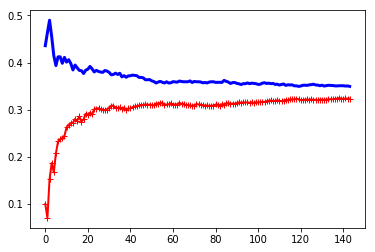

In [39]:
#draw the learning curve on the best estimator.

svc_randomized = SVC(C=891.26008398419549, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.025555406318355806,
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

train_errors, val_errors = [], []
for m in range(100, len(X_tr), 100):
    svc_randomized.fit(X_tr[:m], y_tr_b[:m]) # DO NOT DELETE
    y_train_predict = svc_randomized.predict(X_tr[:m])
    y_val_predict = svc_randomized.predict(X_te[:m])
    train_errors.append(mean_squared_error(y_train_predict, y_tr_b[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_te_b[:m]))
    
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
plt.show()